In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

Data Handling 

In [110]:
base_path = "../Data/eth_final_df.csv"
lstm_path = "../Results/eth_lstm_prediction.csv"
egarch_path = "../Results/eth_egarch_prediction.csv"
xgb_path = "../Results/eth_xgb_prediction.csv"
vanilla_t_path  = "../Results/eth_transformer_prediction.csv"
dense_t_path = "../Results/eth_transformer_dense_prediction.csv"
random_t_path = "../Results/eth_transformer_random_prediction.csv"

df = pd.read_csv(base_path, parse_dates=["timestamp"])
need = ["timestamp", "open", "low", "high", "close", "vol_future"]
df = df[need].copy()


if df["timestamp"].dt.tz is None:
    df["timestamp"] = df["timestamp"].dt.tz_localize("UTC")
df = df.drop_duplicates(subset="timestamp").sort_values("timestamp")


def load_pred(path, new_col_name):
    d = pd.read_csv(path, parse_dates=["timestamp"])
    if d["timestamp"].dt.tz is None:
        d["timestamp"] = d["timestamp"].dt.tz_localize("UTC")
    pred_col = None
    for c in d.columns:
        if c.lower() in {"pred_vol_future", "predicted_volatility", "predicted"}:
            pred_col = c
            break
    if pred_col is None:
        raise ValueError(f"Could not find prediction column in {path}.")
    d = d[["timestamp", pred_col]].rename(columns={pred_col: new_col_name})
    return d.drop_duplicates(subset="timestamp").sort_values("timestamp")

lstm = load_pred(lstm_path, "lstm_pred_vol_future")
egarch = load_pred(egarch_path, "egarch_pred_vol_future")
xgb = load_pred(xgb_path, "xgb_pred_vol_future")  
vanilla_t = load_pred(vanilla_t_path, "vanilla_t_pred_vol_future") 
dense_t = load_pred(dense_t_path, "dense_t_pred_vol_future")
random_t = load_pred(random_t_path, "random_t_pred_vol_future")

master = (df
        .merge(lstm,  on="timestamp", how="left")
        .merge(egarch, on="timestamp", how="left")
        .merge(xgb,   on="timestamp", how="left")
        .merge(vanilla_t, on="timestamp", how="left")
        .merge(dense_t, on="timestamp", how="left")
        .merge(random_t, on="timestamp", how="left")
          )

print("Initial:",len(master))

Initial: 8208


In [111]:
master = master.dropna(subset=[
    "lstm_pred_vol_future",
    "egarch_pred_vol_future",
    "xgb_pred_vol_future",
    "vanilla_t_pred_vol_future",
    "dense_t_pred_vol_future",
    "random_t_pred_vol_future",
]).reset_index(drop=True)

print("After dropping NaNs:", len(master), "rows remain.")
print(master.head(3))
print(master.tail(3))

pred_cols = [c for c in ["lstm_pred_vol_future","egarch_pred_vol_future",
                         "xgb_pred_vol_future", "vanilla_t_pred_vol_future",
                         "dense_t_pred_vol_future", "random_t_pred_vol_future",
                         "tf_pred_vol_future"] if c in master.columns]



After dropping NaNs: 1231 rows remain.
                  timestamp     open      low     high    close  vol_future  \
0 2025-08-22 17:00:00+00:00  4748.60  4748.52  4839.23  4796.19   -4.832117   
1 2025-08-22 18:00:00+00:00  4800.54  4758.02  4800.54  4784.76   -4.931836   
2 2025-08-22 19:00:00+00:00  4786.89  4786.45  4840.05  4837.88   -4.982131   

   lstm_pred_vol_future  egarch_pred_vol_future  xgb_pred_vol_future  \
0             -4.386461                0.018098            -4.786462   
1             -4.590931                0.016870            -4.819179   
2             -4.741147                0.015033            -4.948697   

   vanilla_t_pred_vol_future  dense_t_pred_vol_future  \
0                   0.006539                 0.006684   
1                   0.006947                 0.007467   
2                   0.006524                 0.006521   

   random_t_pred_vol_future  
0                       1.0  
1                       1.0  
2                       1.0  
      

Adding Backtesting Parameters

In [112]:
ALPHAS     = (0.80, 0.85, 0.90, 0.95)    # looser threshold range → more trades, 
Q_WINDOW   = 24*7                        # 7-day rolling window (keep this)
VAL_H      = 24*30                       # 30 days validation (more stable α selection)
TEST_H     = 24*5                        # 5 days test (shorter, rolling forward faster)
EMBARGO_H  = 1                           # keep small gap

FEE_RATE   = 0.001                      # 0.05% per side (test sensitivity to fees)
SPEND_FRAC = 0.05                        # same (or lower to reduce overtrading)
TP_PCT     = 0.02                        # widen target (+2%)
TSL_PCT    = 0.01                        # wider trailing stop (–1%)
INIT_CASH  = 10000.0
H_PER_YR   = 24*365

Features (returns) & utilities

In [113]:
master["ret_log"] = np.log(master["close"]).diff()
master["ret_2h"]  = master["ret_log"].rolling(2).sum()

def rolling_quantile(series, window, alpha):
    # use ONLY past data: shift by 1 hour to avoid look-ahead
    return series.shift(1).rolling(window=window, min_periods=max(6, window//2)).quantile(alpha)

def build_enter_flags(df, pred_col, alpha, q_window, mode):
    q = rolling_quantile(df["vol_future"], q_window, alpha)
    spike = (df[pred_col] > q)
    if mode == "momentum":
        cond = df["ret_2h"] > 0
    elif mode == "meanrev":
        cond = df["ret_2h"] < 0
    else:
        raise ValueError("mode must be 'momentum' or 'meanrev'")

    sig = (spike & cond).astype(bool)
    # decide at hour h close; EXECUTE next hour open
    return sig.shift(1, fill_value=False)



Broker backtest engines

In [114]:
def backtest_block(df_blk, enter_flags,
                   fee_rate=FEE_RATE, spend_frac=SPEND_FRAC,
                   tp=TP_PCT, tsl=TSL_PCT, initial_cash=INIT_CASH):
    
    cash = float(initial_cash)
    qty = 0.0
    entry_px = np.nan
    eq_rows = []
    trades = []
    idx = df_blk.index

    for i in range(1, len(idx)-1):
        t  = idx[i]      
        t1 = idx[i+1]    

        if qty != 0.0:
            px_in = entry_px
            high = df_blk.at[t1, "high"]
            low  = df_blk.at[t1, "low"]
            peak = max(px_in, high)
            stop_lvl   = peak * (1 - tsl)
            target_lvl = px_in * (1 + tp)

            if low <= stop_lvl:
                exit_px, reason = stop_lvl, "TSL"
            elif high >= target_lvl:
                exit_px, reason = target_lvl, "TP"
            else:
                exit_px, reason = df_blk.at[t1, "open"], "Timeout"

            proceeds = qty * exit_px * (1 - fee_rate)
            cash += proceeds
            trades.append(dict(ts=t1, side="SELL", qty=qty, price=exit_px,
                               fee=qty*exit_px*fee_rate, reason=reason))
            qty = 0.0
            entry_px = np.nan

        if bool(enter_flags.loc[t]) and qty == 0.0:
            px_open  = df_blk.at[t, "open"]
            notional = cash * spend_frac
            if px_open > 0 and notional > 0:
                qty = notional / (px_open * (1 + fee_rate))
                cash -= qty * px_open * (1 + fee_rate)
                entry_px = px_open
                trades.append(dict(ts=t, side="BUY", qty=qty, price=px_open,
                                   fee=qty*px_open*fee_rate, reason="Enter"))

        eq_rows.append((t, cash + qty * df_blk.at[t, "close"]))

    eq = pd.DataFrame(eq_rows, columns=["timestamp","equity"]).set_index("timestamp")
    tr = pd.DataFrame(trades)
    return eq, tr, cash

def buy_and_hold_global(df_full, fee_rate=FEE_RATE, initial_cash=INIT_CASH):
    cash = float(initial_cash)
    px_in = df_full.iloc[0]["open"]
    qty = cash / (px_in * (1 + fee_rate))
    cash -= qty * px_in * (1 + fee_rate)
    equity = []
    for i in range(len(df_full)):
        t = df_full.index[i]
        px = df_full.iloc[i]["close"]
        equity.append((t, cash + qty * px))
    return pd.DataFrame(equity, columns=["timestamp","equity"]).set_index("timestamp")

def buy_and_hold_over_windows(df_full, windows,
                              fee_rate=FEE_RATE, initial_cash=INIT_CASH):
    if not windows:
        return pd.DataFrame(columns=["equity"])

    cash = float(initial_cash)
    qty  = 0.0
    eq_rows = []
    first = True

    for (test_start, test_end) in windows:
        seg = df_full.loc[test_start:test_end]
        if seg.empty:
            continue
        # Enter at first bar open of the FIRST segment
        if first:
            px_in = seg.iloc[0]["open"]
            qty   = cash / (px_in * (1 + fee_rate))
            cash -= qty * px_in * (1 + fee_rate)
            first = False
        # Mark to market across this segment
        for i in range(len(seg)):
            t  = seg.index[i]
            px = seg.iloc[i]["close"]
            eq_rows.append((t, cash + qty * px))

    return pd.DataFrame(eq_rows, columns=["timestamp","equity"]).set_index("timestamp")

Metrics

In [115]:
def metrics(eq):
    ret = eq["equity"].pct_change().dropna()
    if len(ret)==0 or ret.std()==0:
        return pd.Series(dict(Sharpe=np.nan, Sortino=np.nan, MaxDD=np.nan,
                              Calmar=np.nan, TotalRet=np.nan, VaR95=np.nan))
    sharpe  = np.sqrt(H_PER_YR) * ret.mean() / ret.std()
    downside= ret[ret<0]
    sortino = np.sqrt(H_PER_YR) * ret.mean() / (downside.std() if downside.std() > 0 else np.nan)
    curve   = eq["equity"]
    maxdd   = (curve/curve.cummax() - 1).min()
    total   = curve.iloc[-1] / curve.iloc[0] - 1
    var95   = np.percentile(ret, 5)
    calmar  = (total + 1e-12) / abs(maxdd) if maxdd < 0 else np.nan
    return pd.Series(dict(Sharpe=sharpe, Sortino=sortino, MaxDD=maxdd,
                          Calmar=calmar, TotalRet=total, VaR95=var95))

Walk Forward Logic 

In [116]:
def walk_forward_per_model(df_full, pred_col, mode,
                           alphas=ALPHAS, q_window=Q_WINDOW,
                           val_hours=VAL_H, test_hours=TEST_H, embargo_hours=EMBARGO_H,
                           fee_rate=FEE_RATE, spend_frac=SPEND_FRAC, tp=TP_PCT, tsl=TSL_PCT,
                           initial_cash=INIT_CASH):

    idx = df_full.index.to_list()  # ensure index slicing works properly
    end = len(idx)
    warmup = max(q_window + 2, 10)
    i = warmup

    eq_segments, trade_segments, chosen_rows, test_windows = [], [], [], []
    cash_carry = float(initial_cash)

    while True:
        val_end = i + val_hours
        test_start = val_end + embargo_hours
        test_end = test_start + test_hours
        if test_end >= end:
            break

        val_idx  = idx[i:val_end]
        test_idx = idx[test_start:test_end]

        # Find best α on validation window
        best_alpha, best_sharpe = None, -np.inf
        for a in alphas:
            enter_val = build_enter_flags(df_full, pred_col, a, q_window, mode).reindex(val_idx)
            eq_val, _, _ = backtest_block(
                df_full.loc[val_idx], enter_val,
                fee_rate=fee_rate, spend_frac=spend_frac, tp=tp, tsl=tsl,
                initial_cash=initial_cash
            )
            ret = eq_val["equity"].pct_change().dropna()
            if not ret.empty and ret.std() > 0:
                sharpe = np.sqrt(H_PER_YR) * ret.mean() / ret.std()
            else:
                sharpe = -np.inf
            if sharpe > best_sharpe:
                best_sharpe, best_alpha = sharpe, a

        # Record chosen α and Sharpe for this block
        chosen_rows.append({
            "val_start": idx[i],
            "val_end": idx[val_end - 1],
            "test_start": idx[test_start],
            "test_end": idx[test_end - 1],
            "chosen_alpha": best_alpha,
            "val_sharpe": best_sharpe
        })
        test_windows.append((idx[test_start], idx[test_end - 1]))

        #  Apply α on test block
        enter_test = build_enter_flags(df_full, pred_col, best_alpha, q_window, mode).reindex(test_idx)
        eq_test, tr_test, cash_carry = backtest_block(
            df_full.loc[test_idx], enter_test,
            fee_rate=fee_rate, spend_frac=spend_frac, tp=tp, tsl=tsl,
            initial_cash=cash_carry
        )

        eq_segments.append(eq_test)
        tr_test["chosen_alpha"] = best_alpha
        trade_segments.append(tr_test)

        i = test_end  # advance window

    # Combine results
    equity_oos = (
        pd.concat(eq_segments).sort_index()
        if eq_segments else pd.DataFrame(columns=["equity"])
    )
    trades_oos = (
        pd.concat(trade_segments, ignore_index=True)
        if trade_segments else pd.DataFrame()
    )
    chosen_log = pd.DataFrame(chosen_rows)
    summary = metrics(equity_oos).to_frame().T if not equity_oos.empty else pd.DataFrame()

    return {
        "equity": equity_oos,
        "trades": trades_oos,
        "chosen_alpha_log": chosen_log,
        "summary": summary,
        "test_windows": test_windows
    }


#store results 
results_by_tag = {}                 

for pred_col in ["lstm_pred_vol_future","egarch_pred_vol_future",
                 "xgb_pred_vol_future", "vanilla_t_pred_vol_future",
                 "dense_t_pred_vol_future", "random_t_pred_vol_future",
                 ]:
    for mode in ["momentum","meanrev"]:
        tag = f"{pred_col}__{mode}"
        results_by_tag[tag] = walk_forward_per_model(master, pred_col, mode)

Chosen alpha by block 

In [117]:
alpha_rows = []

for tag, res in results_by_tag.items():
    log = res.get("chosen_alpha_log")
    if log is None or log.empty:
        continue

    # tag looks like "xgb_pred_vol_future__momentum"
    parts = tag.split("__")
    model = parts[0]
    strategy = parts[1] if len(parts) > 1 else "NA"

    tmp = log[["val_start","val_end","test_start","test_end","chosen_alpha","val_sharpe"]].copy()
    tmp["Model"] = model
    tmp["Strategy"] = strategy
    alpha_rows.append(tmp)

alpha_table = (
    pd.concat(alpha_rows, ignore_index=True)
      .sort_values(["test_start","Model","Strategy"])
      .reset_index(drop=True)
)

print("\n=== Chosen α by block (per model × strategy) ===")
print(alpha_table.to_string(index=False))



=== Chosen α by block (per model × strategy) ===
 val_start  val_end  test_start  test_end  chosen_alpha  val_sharpe                     Model Strategy
       170      889         891      1010          0.80  -15.922649   dense_t_pred_vol_future  meanrev
       170      889         891      1010          0.80  -16.213881   dense_t_pred_vol_future momentum
       170      889         891      1010          0.80  -15.922649    egarch_pred_vol_future  meanrev
       170      889         891      1010          0.80  -16.213881    egarch_pred_vol_future momentum
       170      889         891      1010          0.95    3.285937      lstm_pred_vol_future  meanrev
       170      889         891      1010          0.80   -4.232025      lstm_pred_vol_future momentum
       170      889         891      1010          0.80  -15.922649  random_t_pred_vol_future  meanrev
       170      889         891      1010          0.80  -16.213881  random_t_pred_vol_future momentum
       170      889    

Trades per test block

In [118]:
trade_rows = []

# Loop through all model-strategy results
for tag, res in results_by_tag.items():
    tr = res.get("trades")
    log = res.get("chosen_alpha_log")

    if tr is None or tr.empty or log is None or log.empty:
        continue

    model, strategy = tag.split("__")

    # For each validation-test block in chosen_alpha_log
    for _, r in log.iterrows():
        mask = (tr["ts"] >= r["test_start"]) & (tr["ts"] <= r["test_end"])
        trade_rows.append({
            "Model": model,
            "Strategy": strategy,
            "test_start": r["test_start"],
            "test_end": r["test_end"],
            "trades_in_block": int(mask.sum()),
            "chosen_alpha": r["chosen_alpha"]
        })

# Combine into one DataFrame
trades_per_block = (
    pd.DataFrame(trade_rows)
      .sort_values(["test_start", "Model", "Strategy"])
      .reset_index(drop=True)
)

print("\n=== Trades per test block ===")
print(trades_per_block.to_string(index=False))



=== Trades per test block ===
                    Model Strategy  test_start  test_end  trades_in_block  chosen_alpha
  dense_t_pred_vol_future  meanrev       891.0    1010.0              119           0.8
  dense_t_pred_vol_future momentum       891.0    1010.0              116           0.8
   egarch_pred_vol_future  meanrev       891.0    1010.0              119           0.8
   egarch_pred_vol_future momentum       891.0    1010.0              116           0.8
     lstm_pred_vol_future momentum       891.0    1010.0               14           0.8
 random_t_pred_vol_future  meanrev       891.0    1010.0              119           0.8
 random_t_pred_vol_future momentum       891.0    1010.0              116           0.8
vanilla_t_pred_vol_future  meanrev       891.0    1010.0              119           0.8
vanilla_t_pred_vol_future momentum       891.0    1010.0              116           0.8


Equity Curves for each model and strategy 

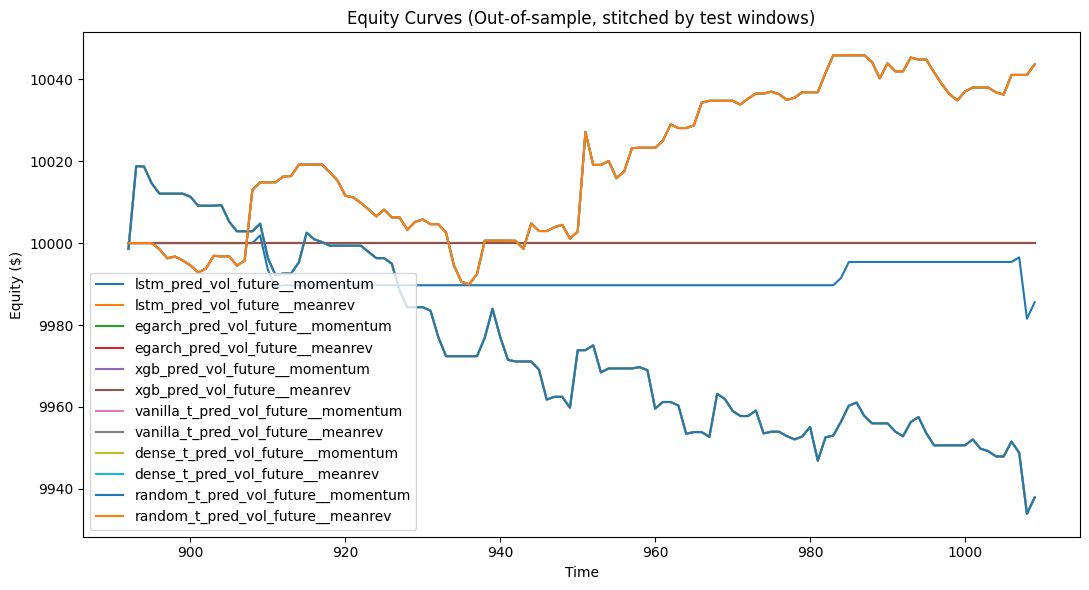


=== Equity Summary (OOS) ===
                                      FinalEquity  TotalReturn
egarch_pred_vol_future__meanrev      10043.630610     0.004363
vanilla_t_pred_vol_future__meanrev   10043.630610     0.004363
dense_t_pred_vol_future__meanrev     10043.630610     0.004363
random_t_pred_vol_future__meanrev    10043.630610     0.004363
lstm_pred_vol_future__meanrev        10000.000000     0.000000
xgb_pred_vol_future__momentum        10000.000000     0.000000
xgb_pred_vol_future__meanrev         10000.000000     0.000000
lstm_pred_vol_future__momentum        9985.565237    -0.001443
egarch_pred_vol_future__momentum      9937.936958    -0.006064
vanilla_t_pred_vol_future__momentum   9937.936958    -0.006064
dense_t_pred_vol_future__momentum     9937.936958    -0.006064
random_t_pred_vol_future__momentum    9937.936958    -0.006064


In [119]:
all_equity = {}

for tag, res in results_by_tag.items():
    eq = res.get("equity")
    if eq is None or eq.empty:
        continue

    if "timestamp" in eq.columns:
        e = (eq[["timestamp", "equity"]]
             .dropna()
             .set_index("timestamp")
             .sort_index())
    elif "ts" in eq.columns:
        e = (eq[["ts", "equity"]]
             .rename(columns={"ts": "timestamp"})
             .dropna()
             .set_index("timestamp")
             .sort_index())
    else:
        e = eq[["equity"]].copy()
        e.index.name = "timestamp"

    e["equity"] = e["equity"].astype(float)
    all_equity[tag] = e

equity_panel = (
    pd.concat({tag: df["equity"] for tag, df in all_equity.items()}, axis=1)
      .sort_index()
)


plt.figure(figsize=(11,6))
for col in equity_panel.columns:
    plt.plot(equity_panel.index, equity_panel[col], label=col)
plt.legend(loc="best")
plt.title("Equity Curves (Out-of-sample, stitched by test windows)")
plt.xlabel("Time")
plt.ylabel("Equity ($)")
plt.tight_layout()
plt.show()

first_row = equity_panel.dropna(how="all").iloc[0]
last_row  = equity_panel.ffill().iloc[-1]

equity_summary = pd.DataFrame({
    "FinalEquity": last_row,
    "TotalReturn": (last_row / first_row) - 1.0
}).sort_values("FinalEquity", ascending=False)

print("\n=== Equity Summary (OOS) ===")
print(equity_summary.to_string())


Summary of Results 

In [120]:
pred_cols_present = [c for c in pred_cols if c in master.columns]
modes = ["momentum", "meanrev"]

all_summaries = []
all_equities  = {}
all_trades    = {}
all_choices   = {}

# Global Buy & Hold (full period)
bh_global = buy_and_hold_global(master)

for m in pred_cols_present:
    for mode in modes:
        res = walk_forward_per_model(
            master, pred_col=m, mode=mode,
            alphas=ALPHAS, q_window=Q_WINDOW,
            val_hours=VAL_H, test_hours=TEST_H, embargo_hours=EMBARGO_H,
            fee_rate=FEE_RATE, spend_frac=SPEND_FRAC, tp=TP_PCT, tsl=TSL_PCT,
            initial_cash=INIT_CASH
        )
        tag = m + "__" + mode
        all_equities[tag] = res["equity"]
        all_trades[tag]   = res["trades"]
        all_choices[tag]  = res["chosen_alpha_log"]
        s = res["summary"].copy()
        s.insert(0, "Model", m)
        s.insert(1, "Strategy", mode)
        all_summaries.append(s)

# Build a stitched Buy&Hold over the SAME test windows 
all_windows = []
for v in all_choices.values():
    if not v.empty:
        for _, r in v.iterrows():
            all_windows.append((r["test_start"], r["test_end"]))
all_windows = sorted(list(set(all_windows)))
bh_stitched = buy_and_hold_over_windows(master, all_windows)

# Collect summaries
summary_table = pd.concat(all_summaries, ignore_index=True) if all_summaries else pd.DataFrame()
if not bh_global.empty:
    s_bh_global = metrics(bh_global).to_frame().T
    s_bh_global.insert(0, "Model", "Buy&Hold_Global")
    s_bh_global.insert(1, "Strategy", "Hold")
    summary_table = pd.concat([summary_table, s_bh_global], ignore_index=True)

if not bh_stitched.empty:
    s_bh_stitch = metrics(bh_stitched).to_frame().T
    s_bh_stitch.insert(0, "Model", "Buy&Hold_Stitched")
    s_bh_stitch.insert(1, "Strategy", "Hold(test-windows)")
    summary_table = pd.concat([summary_table, s_bh_stitch], ignore_index=True)

print(summary_table.round(4))

                        Model            Strategy   Sharpe  Sortino   MaxDD  \
0        lstm_pred_vol_future            momentum  -6.6409  -2.1344 -0.0020   
1        lstm_pred_vol_future             meanrev      NaN      NaN     NaN   
2      egarch_pred_vol_future            momentum -11.8941 -16.3228 -0.0085   
3      egarch_pred_vol_future             meanrev   9.6753  20.3659 -0.0029   
4         xgb_pred_vol_future            momentum      NaN      NaN     NaN   
5         xgb_pred_vol_future             meanrev      NaN      NaN     NaN   
6   vanilla_t_pred_vol_future            momentum -11.8941 -16.3228 -0.0085   
7   vanilla_t_pred_vol_future             meanrev   9.6753  20.3659 -0.0029   
8     dense_t_pred_vol_future            momentum -11.8941 -16.3228 -0.0085   
9     dense_t_pred_vol_future             meanrev   9.6753  20.3659 -0.0029   
10   random_t_pred_vol_future            momentum -11.8941 -16.3228 -0.0085   
11   random_t_pred_vol_future             meanrev   

In [121]:
def _tag_to_ms(tag: str):
    return tag.split("__", 1) if "__" in tag else (tag, "unknown")

def _trades_df_from_dict(all_trades: dict) -> pd.DataFrame:
    rows = []
    for tag, df in all_trades.items():
        m, s = _tag_to_ms(tag)
        if isinstance(df, pd.DataFrame) and not df.empty:
            tmp = df.copy()
            tmp["Model"] = m
            tmp["Strategy"] = s
            rows.append(tmp[["Model","Strategy"]])
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["Model","Strategy"])

def _alpha_df_from_dict(all_choices: dict) -> pd.DataFrame:
    rows = []
    for tag, df in all_choices.items():
        m, s = _tag_to_ms(tag)
        if isinstance(df, pd.DataFrame) and not df.empty:
            tmp = df.copy()
            tmp["Model"] = m
            tmp["Strategy"] = s
            rows.append(tmp[["Model","Strategy","chosen_alpha"]])
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["Model","Strategy","chosen_alpha"])

def build_leaderboard(summary_table: pd.DataFrame,
                      all_trades: dict | None = None,
                      all_choices: dict | None = None,
                      sort_by: str = "Sharpe",
                      ascending: bool = False) -> pd.DataFrame:
    """
    summary_table must include: ['Model','Strategy', 'TotalRet','Sharpe','Sortino','Calmar','MaxDD','VaR95']
    """
    lb = summary_table.copy()

    # Attach Trades (count) if available
    if all_trades is not None:
        trades_df = _trades_df_from_dict(all_trades)
        if not trades_df.empty:
            trades_ct = trades_df.groupby(["Model","Strategy"], as_index=False).size().rename(columns={"size":"Trades"})
            lb = lb.merge(trades_ct, on=["Model","Strategy"], how="left")
        else:
            lb["Trades"] = np.nan
    else:
        lb["Trades"] = np.nan

    # Attach median alpha if available
    if all_choices is not None:
        alpha_df = _alpha_df_from_dict(all_choices)
        if not alpha_df.empty:
            a_med = alpha_df.groupby(["Model","Strategy"], as_index=False)["chosen_alpha"]\
                            .median().rename(columns={"chosen_alpha":"Alpha_median"})
            lb = lb.merge(a_med, on=["Model","Strategy"], how="left")
        else:
            lb["Alpha_median"] = np.nan
    else:
        lb["Alpha_median"] = np.nan

    # Avg PnL per trade (rough sanity check)
    lb["AvgTradePnL"] = np.where(lb["Trades"].fillna(0) > 0,
                                 lb["TotalRet"] / lb["Trades"].replace({0:np.nan}),
                                 np.nan)

    # Order & rank
    cols = ["Model","Strategy","TotalRet","Sharpe","Sortino","Calmar","MaxDD","VaR95","Trades","AvgTradePnL","Alpha_median"]
    cols = [c for c in cols if c in lb.columns]
    lb = lb[cols].sort_values(sort_by, ascending=ascending, ignore_index=True)
    return lb


In [122]:
# ===== Build and show leaderboards (ranked by Sharpe) =====
leaderboard_all = build_leaderboard(summary_table, all_trades=all_trades, all_choices=all_choices, sort_by="Sharpe", ascending=False)

leaderboard_meanrev  = leaderboard_all[leaderboard_all["Strategy"].str.contains("meanrev", case=False, na=False)]\
                        .reset_index(drop=True)
leaderboard_momentum = leaderboard_all[leaderboard_all["Strategy"].str.contains("momentum", case=False, na=False)]\
                        .reset_index(drop=True)

print("=== Leaderboard (ALL) ===")
display(leaderboard_all.round(4))

print("=== Leaderboard (Mean-Reversion) ===")
display(leaderboard_meanrev.round(4))

print("=== Leaderboard (Momentum) ===")
display(leaderboard_momentum.round(4))

=== Leaderboard (ALL) ===


,Model,Strategy,TotalRet,Sharpe,Sortino,Calmar,MaxDD,VaR95,Trades,AvgTradePnL,Alpha_median
0,Buy&Hold_Stitched,Hold(test-windows),0.1135,14.6580,30.6908,3.9632,-0.0286,-0.0056,NaN,NaN,NaN
1,egarch_pred_vol_future,meanrev,0.0044,9.6753,20.3659,1.4968,-0.0029,-0.0003,119.0,0.0000,0.80
2,vanilla_t_pred_vol_future,meanrev,0.0044,9.6753,20.3659,1.4968,-0.0029,-0.0003,119.0,0.0000,0.80
3,dense_t_pred_vol_future,meanrev,0.0044,9.6753,20.3659,1.4968,-0.0029,-0.0003,119.0,0.0000,0.80
4,random_t_pred_vol_future,meanrev,0.0044,9.6753,20.3659,1.4968,-0.0029,-0.0003,119.0,0.0000,0.80
5,Buy&Hold_Global,Hold,-0.1340,-1.5445,-1.8786,-0.5344,-0.2507,-0.0087,NaN,NaN,NaN
6,lstm_pred_vol_future,momentum,-0.0014,-6.6409,-2.1344,-0.7107,-0.0020,0.0000,14.0,-0.0001,0.80
7,egarch_pred_vol_future,momentum,-0.0061,-11.8941,-16.3228,-0.7162,-0.0085,-0.0007,116.0,-0.0001,0.80
8,vanilla_t_pred_vol_future,momentum,-0.0061,-11.8941,-16.3228,-0.7162,-0.0085,-0.0007,116.0,-0.0001,0.80
9,dense_t_pred_vol_future,momentum,-0.0061,-11.8941,-16.3228,-0.7162,-0.0085,-0.0007,116.0,-0.0001,0.80


=== Leaderboard (Mean-Reversion) ===


,Model,Strategy,TotalRet,Sharpe,Sortino,Calmar,MaxDD,VaR95,Trades,AvgTradePnL,Alpha_median
0,egarch_pred_vol_future,meanrev,0.0044,9.6753,20.3659,1.4968,-0.0029,-0.0003,119.0,0.0,0.80
1,vanilla_t_pred_vol_future,meanrev,0.0044,9.6753,20.3659,1.4968,-0.0029,-0.0003,119.0,0.0,0.80
2,dense_t_pred_vol_future,meanrev,0.0044,9.6753,20.3659,1.4968,-0.0029,-0.0003,119.0,0.0,0.80
3,random_t_pred_vol_future,meanrev,0.0044,9.6753,20.3659,1.4968,-0.0029,-0.0003,119.0,0.0,0.80
4,lstm_pred_vol_future,meanrev,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.95
5,xgb_pred_vol_future,meanrev,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.95


=== Leaderboard (Momentum) ===


,Model,Strategy,TotalRet,Sharpe,Sortino,Calmar,MaxDD,VaR95,Trades,AvgTradePnL,Alpha_median
0,lstm_pred_vol_future,momentum,-0.0014,-6.6409,-2.1344,-0.7107,-0.0020,0.0000,14.0,-0.0001,0.8
1,egarch_pred_vol_future,momentum,-0.0061,-11.8941,-16.3228,-0.7162,-0.0085,-0.0007,116.0,-0.0001,0.8
2,vanilla_t_pred_vol_future,momentum,-0.0061,-11.8941,-16.3228,-0.7162,-0.0085,-0.0007,116.0,-0.0001,0.8
3,dense_t_pred_vol_future,momentum,-0.0061,-11.8941,-16.3228,-0.7162,-0.0085,-0.0007,116.0,-0.0001,0.8
4,random_t_pred_vol_future,momentum,-0.0061,-11.8941,-16.3228,-0.7162,-0.0085,-0.0007,116.0,-0.0001,0.8
5,xgb_pred_vol_future,momentum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9


Volatility–quintile performance plot

Coverage by series (rows after pct_change):
                        Model  Strategy  n_rows
0     dense_t_pred_vol_future   meanrev     117
1     dense_t_pred_vol_future  momentum     117
2      egarch_pred_vol_future   meanrev     117
3      egarch_pred_vol_future  momentum     117
4        lstm_pred_vol_future   meanrev     117
5        lstm_pred_vol_future  momentum     117
6    random_t_pred_vol_future   meanrev     117
7    random_t_pred_vol_future  momentum     117
8   vanilla_t_pred_vol_future   meanrev     117
9   vanilla_t_pred_vol_future  momentum     117
10        xgb_pred_vol_future   meanrev     117
11        xgb_pred_vol_future  momentum     117


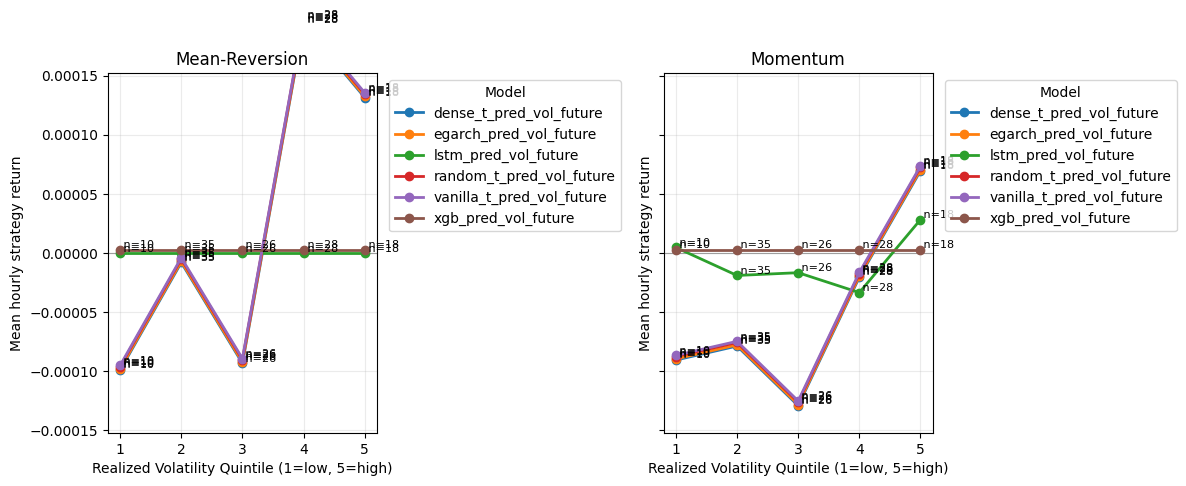

In [124]:
# --- Robust RV–quintile perf plot with diagnostics (no inner merge loss) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



def plot_rv_quintile_perf(master, results_by_tag):
    # 1) Collect equity
    rows = []
    for tag, res in results_by_tag.items():
        model, strat = tag.split("__", 1) if "__" in tag else (tag, "unknown")
        eq = res.get("equity")
        if isinstance(eq, pd.DataFrame) and not eq.empty:
            df = eq.rename(columns={"equity": "Equity"}).copy()
            df["Time"] = df.index
            df["Model"] = model
            df["Strategy"] = strat
            rows.append(df[["Time","Equity","Model","Strategy"]])
    equity_long = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["Time","Equity","Model","Strategy"])

    if equity_long.empty:
        print("No equity data available.")
        return

    # 2) Build RV quintiles on master and map by index (no merge)
    if "vol_future" not in master.columns:
        raise ValueError("master must contain 'vol_future'.")

    # Ensure types line up for mapping
    # If both are datetimes or both are the same dtype, a direct map works.
    vol_map = None
    if equity_long["Time"].dtype == master.index.dtype:
        tmp = master["vol_future"].copy()
        vol_q = pd.qcut(tmp.rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
        vol_map = vol_q
    else:
        # fallback: try to coerce both to datetime and remap
        try:
            eq_time = pd.to_datetime(equity_long["Time"])
            ms_time = pd.to_datetime(master.index)
            # build mapping on datetime index
            tmp = pd.Series(master["vol_future"].values, index=ms_time)
            vol_q = pd.qcut(tmp.rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
            # align by exact timestamp; if missing, leave NaN
            vol_map = vol_q
            equity_long["Time"] = eq_time
        except Exception:
            # final fallback: map by position (assumes same ordering)
            tmp = master["vol_future"].reset_index(drop=True)
            vol_q = pd.qcut(tmp.rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
            equity_long = equity_long.reset_index(drop=True)
            equity_long["__rowpos__"] = np.arange(len(equity_long))
            # simple position-based assignment (best-effort)
            equity_long["vol_q"] = vol_q.reindex(equity_long["__rowpos__"]).values
            equity_long.drop(columns="__rowpos__", inplace=True)
            print("[warn] Using positional mapping for vol_q; check time alignment.")
            vol_map = None

    if vol_map is not None:
        # map by exact index/time
        equity_long["vol_q"] = equity_long["Time"].map(vol_map)

    # Diagnostics: what got no vol_q?
    miss = equity_long["vol_q"].isna().groupby([equity_long["Model"], equity_long["Strategy"]]).sum()
    if miss.sum() > 0:
        print("Rows with missing vol_q (likely time misalignment):")
        print(miss[miss > 0].sort_values(ascending=False).head(10))

    # 3) Returns and filtering
    equity_long = equity_long.sort_values(["Model","Strategy","Time"])
    equity_long["strat_ret"] = equity_long.groupby(["Model","Strategy"])["Equity"].pct_change()
    eqr = equity_long.dropna(subset=["vol_q","strat_ret"]).copy()

    # Diagnostics: which series are empty after returns?
    counts = eqr.groupby(["Model","Strategy"]).size().reset_index(name="n_rows")
    if counts.empty:
        print("All series empty after pct_change/join. Check time alignment.")
        return
    print("Coverage by series (rows after pct_change):")
    print(counts.sort_values("n_rows", ascending=False).head(20))

    # 4) Aggregate by RV quintile
    agg = (
        eqr.groupby(["Model","Strategy","vol_q"])
           .agg(mean_ret=("strat_ret","mean"), N=("strat_ret","size"))
           .reset_index()
    )

    # Include all quintiles 1..5 per (Model,Strategy)
    QALL = pd.Index([1,2,3,4,5], name="vol_q")
    def _ensure_quintiles(df_sub):
        out = []
        for (m, s), g in df_sub.groupby(["Model","Strategy"]):
            g2 = g.set_index("vol_q").reindex(QALL)
            g2["Model"] = m; g2["Strategy"] = s
            out.append(g2.reset_index())
        return pd.concat(out, ignore_index=True) if out else pd.DataFrame(columns=["vol_q","mean_ret","N","Model","Strategy"])

    agg_full = _ensure_quintiles(agg)
    def _panel(df, title, ax):
        if df.empty:
            ax.set_title(title); ax.axis("off"); return

        # Compute a small vertical jitter per model so overlapping ~0 lines are visible
        models = sorted(df["Model"].unique())
        jitter_map = {m: (i - (len(models)-1)/2)*1e-6 for i, m in enumerate(models)}  # adjust 1e-6 if needed

        # Robust y-limits: ignore extreme outliers when autoscaling
        yvals = df["mean_ret"].dropna().to_numpy()
        if len(yvals):
            lo, hi = np.percentile(yvals, [1, 99])
            rng = max(abs(lo), abs(hi))
            ax.set_ylim(-1.2*rng, 1.2*rng)

        ax.axhline(0.0, color="k", lw=0.8, alpha=0.4, zorder=0)  # zero reference

        for m, g in df.groupby("Model"):
            g = g.sort_values("vol_q").copy()
            # apply tiny jitter if values are near zero
            jitter = jitter_map[m]
            g["plot_y"] = g["mean_ret"].fillna(0.0) + jitter
            ax.plot(g["vol_q"], g["plot_y"], marker="o", lw=2, ms=6, label=m)
            for x, y, n in zip(g["vol_q"], g["plot_y"], g["N"]):
                ax.text(x, y, f" n={int(n) if np.isfinite(n) else 0}", fontsize=8, va="bottom")

        ax.set_title(title)
        ax.set_xlabel("Realized Volatility Quintile (1=low, 5=high)")
        ax.set_ylabel("Mean hourly strategy return")
        ax.grid(alpha=0.25)
        ax.legend(bbox_to_anchor=(1.02,1), loc="upper left", title="Model")

    fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

    mr  = agg_full[agg_full["Strategy"].str.contains("meanrev",  case=False, na=False)]
    mom = agg_full[agg_full["Strategy"].str.contains("momentum", case=False, na=False)]

    _panel(mr,  "Mean-Reversion", axes[0])
    _panel(mom, "Momentum",       axes[1])

    plt.tight_layout()
    plt.show()


# ---- call it
plot_rv_quintile_perf(master, results_by_tag)
